### Linear regression and regularization for feature selection

We try to perform linear regression on the dataset that we created and then use regularization to see which features are the most prominent predictors of food insecurity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error

In [2]:
base_data = pd.read_csv('../data/final_dataset.csv')

In [3]:
base_data.columns.values

array(['CountryCode', 'Country', 'Year', 'Population', 'FoodSupplyQty',
       'FoodSupplyCal', 'Losses', 'ExpenditureShare', 'TempChange',
       'PoliticalStabilityIndex', 'FoodInflation', 'UndernourishedPeople',
       'UndernourishedPercent', 'SevereInsecurePeople',
       'ModerateSevereInsecurePeople', 'ModerateSevereInsecurePercent',
       'SevereInsecurePercent', 'PurchasingPower', 'LossesPerCapita'],
      dtype=object)

In [4]:
def correlation_matrix(regression_data, food_insecurity_labels):
    x_ = range(len(food_insecurity_labels))
    cor = regression_data[food_insecurity_labels].corr()

    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    im = ax.imshow(cor)
    ax.set_xticks(x_)
    ax.set_yticks(x_)
    ax.set_xticklabels(food_insecurity_labels, rotation=90)
    ax.set_yticklabels(food_insecurity_labels, rotation=0)

    plt.colorbar(im, ax=ax)
    plt.show()

In [5]:
def basic_regression(regression_data, y_column):
    # removing rows with NaN values, since we only want full contributions to the data
    regression_data.dropna(inplace=True)
    food_insecurity_labels = regression_data.drop(y_column, axis=1).columns.values
    
    food_insecurity_index = regression_data[y_column].values
    food_insecurity_predictors = regression_data[food_insecurity_labels].values
    
    # standardizing our predictors
    scaler = preprocessing.StandardScaler().fit(food_insecurity_predictors)
    scaled_fi_predictors = scaler.transform(food_insecurity_predictors)

    # # regressing the model
    regression_model = LinearRegression(fit_intercept=True).fit(scaled_fi_predictors, food_insecurity_index)
    basic_prediction = regression_model.predict(scaled_fi_predictors)
    print("MSE for Basic: " + str(mean_squared_error(food_insecurity_index, basic_prediction)))
    
    fig = plt.figure(figsize = (15, 10))
    plt.bar(food_insecurity_labels, regression_model.coef_)
    plt.xlabel('Features')
    plt.ylabel('Coefficient Values')
    plt.title(y_column, fontsize=15)
    plt.xticks()
    plt.show()
    correlation_matrix(regression_data, food_insecurity_labels)

In [6]:
def regularized_regression(regression_data, y_column):
    regression_data.dropna(inplace=True)
    food_insecurity_labels = regression_data.drop(y_column, axis=1).columns.values
    food_insecurity_index = regression_data[y_column].values
    food_insecurity_predictors = regression_data[food_insecurity_labels].values
    
    # standardizing our predictors
    scaler = preprocessing.StandardScaler().fit(food_insecurity_predictors)
    scaled_fi_predictors = scaler.transform(food_insecurity_predictors)
    
    # hyperparameter optimization
    alpha_values = np.logspace(-3, 3, 7)
    scores_lasso = []
    scores_ridge = []
    cv = 5

    for a in alpha_values:
        clf_ridge = make_pipeline(
            preprocessing.StandardScaler(),
            Ridge(alpha=a, fit_intercept=True)
        )
        s_ridge = np.sum(
            cross_val_score(
                clf_ridge,
                food_insecurity_predictors,
                food_insecurity_index,
                cv=cv
            )
        )
        clf_lasso = make_pipeline(
            preprocessing.StandardScaler(),
            Lasso(alpha=a, fit_intercept=True, max_iter=10000)
        )
        s_lasso = np.sum(
            cross_val_score(
                clf_lasso,
                food_insecurity_predictors,
                food_insecurity_index,
                cv=cv
            )
        )
        scores_ridge.append(s_ridge)
        scores_lasso.append(s_lasso)
    
    lasso_alpha = alpha_values[np.argmax(scores_lasso)]
    ridge_alpha = alpha_values[np.argmax(scores_ridge)]
    lasso_regression_model = Lasso(
        alpha=lasso_alpha,
        fit_intercept=True
    ).fit(
        scaled_fi_predictors
        , food_insecurity_index
    )
    ridge_regression_model = Ridge(
        alpha=ridge_alpha
        , fit_intercept=True
    ).fit(
        scaled_fi_predictors,
        food_insecurity_index
    )
    
    # calculating how good the fit is
    lasso_prediction = lasso_regression_model.predict(scaled_fi_predictors)
    ridge_prediction = ridge_regression_model.predict(scaled_fi_predictors)
    print("MSE for Lasso: " + str(mean_squared_error(food_insecurity_index, lasso_prediction)))
    print("MSE for Ridge: " + str(mean_squared_error(food_insecurity_index, ridge_prediction)))
    
    fig, ax = plt.subplots(2, 1, figsize=(15,10))

    ax[0].bar(food_insecurity_labels, lasso_regression_model.coef_)
    ax[1].bar(food_insecurity_labels, ridge_regression_model.coef_)
    ax[0].set_xlabel('Features')
    ax[0].set_title('Lasso Regularization', fontsize=12)
    ax[0].set_ylabel('Coefficient Value')
    ax[1].set_title('Ridge Regularization', fontsize=12)
    ax[1].set_xlabel('Features')
    ax[1].set_ylabel('Coefficient Value')
    plt.show()

In [7]:
# We are replacing the values that are deemed too insignificant to calculate and are
# reported in the dataset in the format: '<X' by their upper bound X.
for l in ["UndernourishedPercent", "ModerateSevereInsecurePeople", "SevereInsecurePercent"]:
    base_data[l] = base_data[l].str.replace('<', '')

MSE for Basic: 224.66936790605885


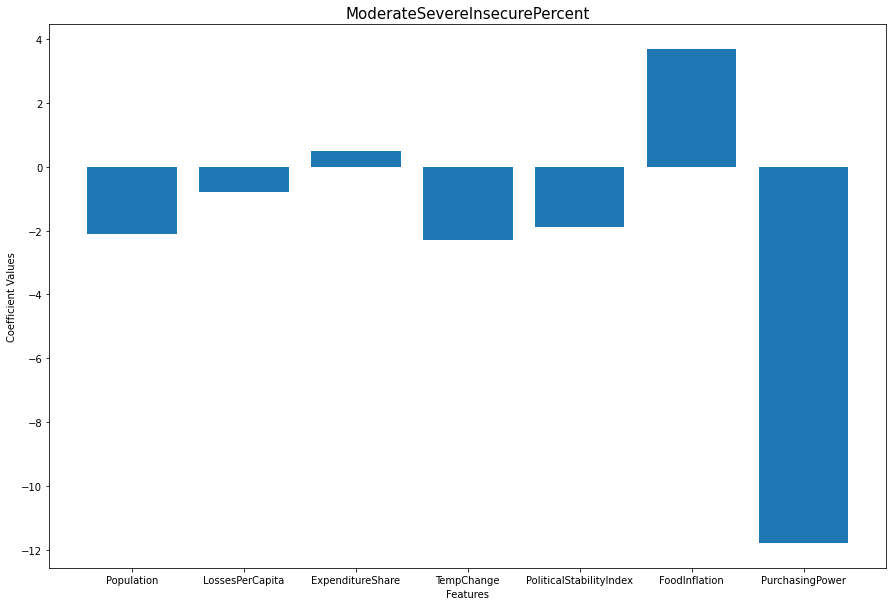

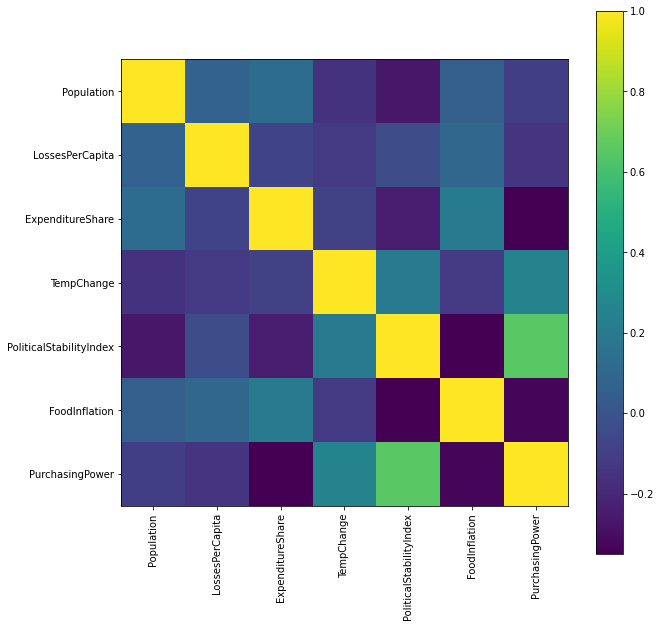

MSE for Lasso: 229.53660747928788
MSE for Ridge: 303.4655403826427


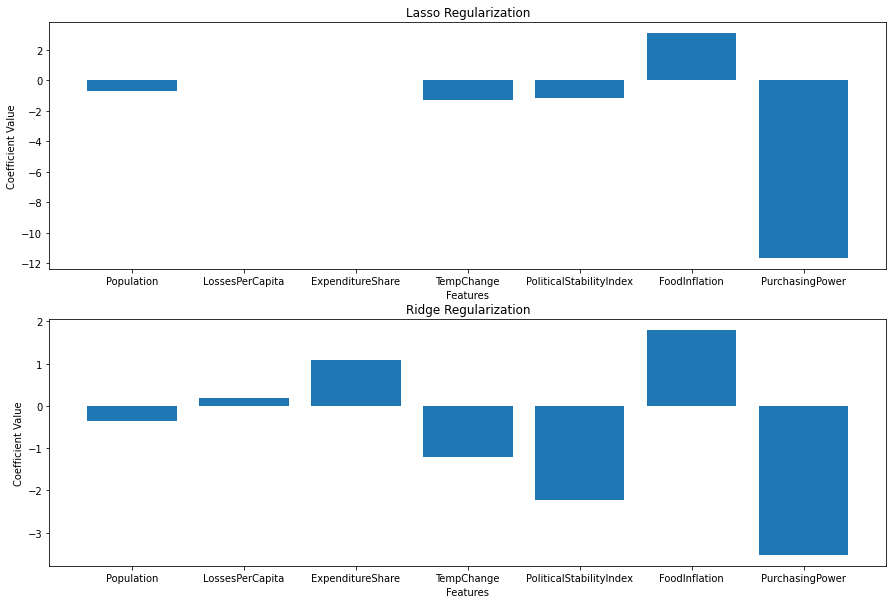

In [8]:
regression_data = base_data[[
    'Population',
#     'FoodSupplyQty',
#     'FoodSupplyCal',
    'LossesPerCapita',
    'ExpenditureShare',
    'TempChange',
    'PoliticalStabilityIndex',
    'FoodInflation',
#     'UndernourishedPercent',
    'PurchasingPower',
    'ModerateSevereInsecurePercent'
]].reset_index(drop=True)

basic_regression(regression_data, 'ModerateSevereInsecurePercent')
regularized_regression(regression_data, 'ModerateSevereInsecurePercent')


MSE for Basic: 58.35385733469417


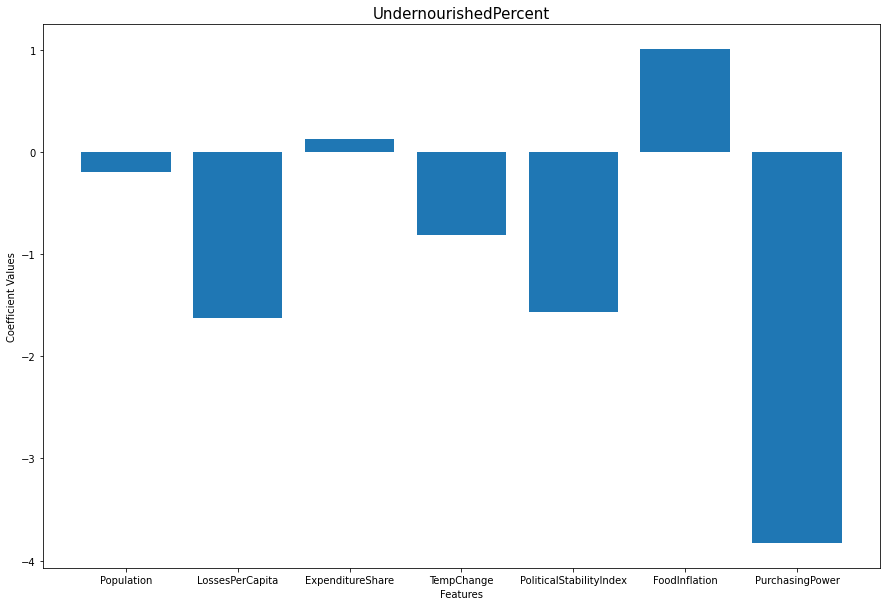

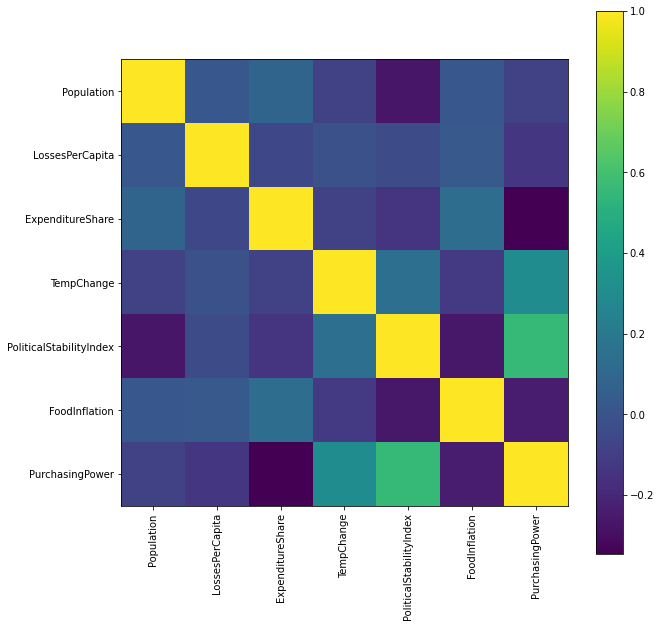

MSE for Lasso: 61.8941104388296
MSE for Ridge: 60.609575518728604


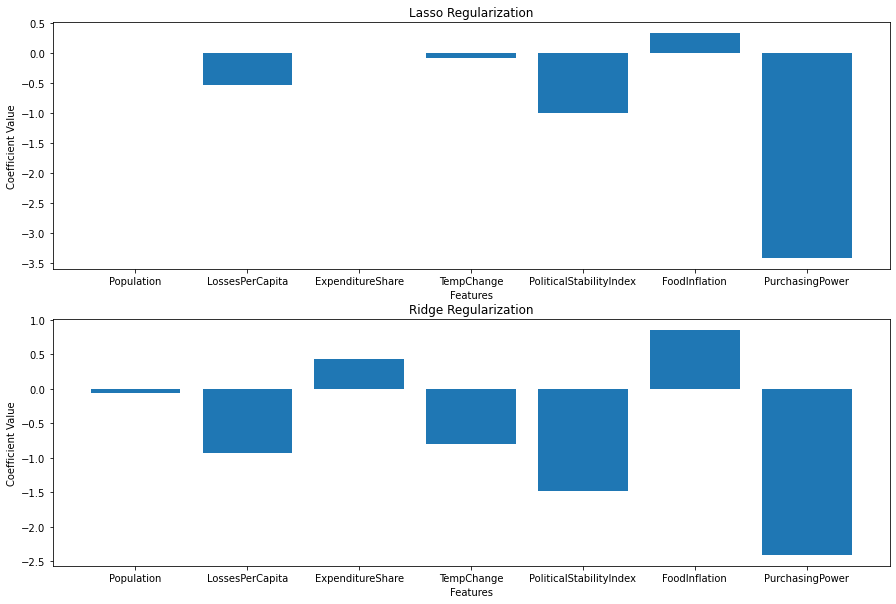

In [9]:
regression_data2 = base_data[[
    'Population',
#     'FoodSupplyQty',
#     'FoodSupplyCal',
    'LossesPerCapita',
    'ExpenditureShare',
    'TempChange',
    'PoliticalStabilityIndex',
    'FoodInflation',
    'UndernourishedPercent',
    'PurchasingPower',
#     'ModerateSevereInsecurePercent'
]].reset_index(drop=True)

basic_regression(regression_data2, 'UndernourishedPercent')
regularized_regression(regression_data2, 'UndernourishedPercent')


MSE for Basic: 82.16108530050668


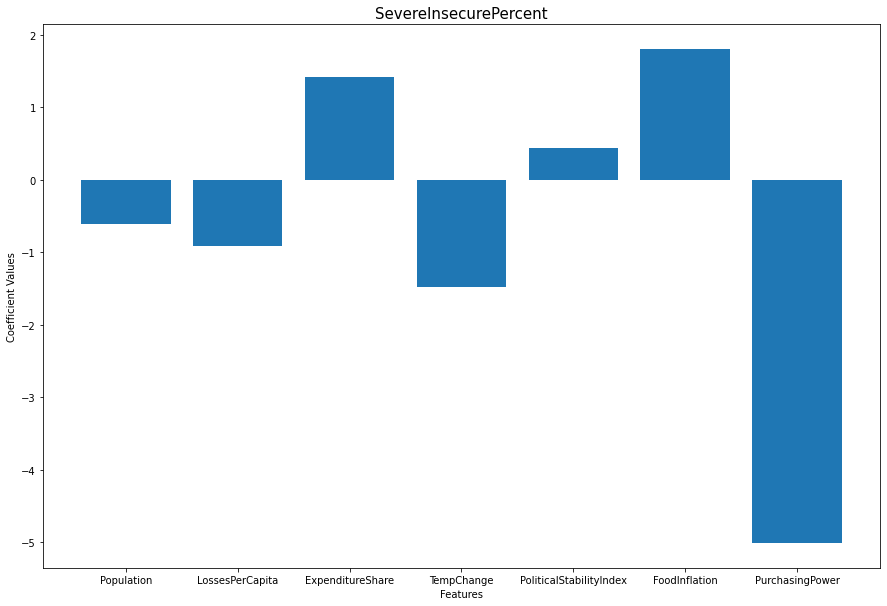

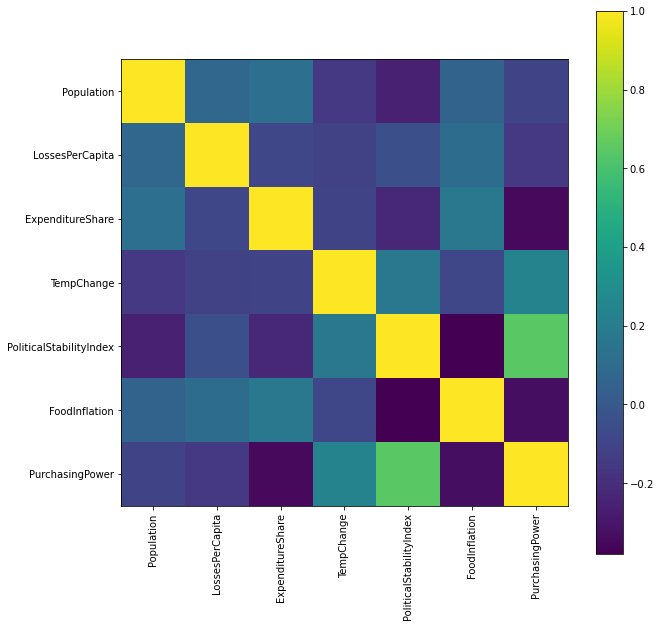

MSE for Lasso: 86.03508218150091
MSE for Ridge: 97.03498818732307


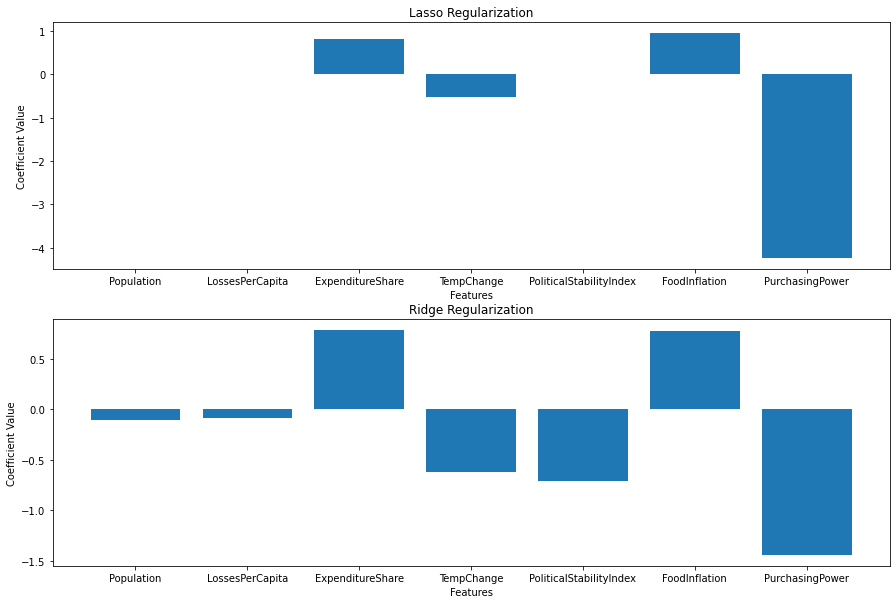

In [10]:
regression_data3 = base_data[[
    'Population',
#     'FoodSupplyQty',
#     'FoodSupplyCal',
    'LossesPerCapita',
    'ExpenditureShare',
    'TempChange',
    'PoliticalStabilityIndex',
    'FoodInflation',
#     'UndernourishedPercent',
    'PurchasingPower',
    'SevereInsecurePercent'
]].reset_index(drop=True)

basic_regression(regression_data3, 'SevereInsecurePercent')
regularized_regression(regression_data3, 'SevereInsecurePercent')

### FINDINGS AND RESULTS TO INVESTIGATE

- Important features: PurchasingPower, FoodInflation, PoliticalStabilityIndex
- Points of interest:
 - Population not playing a role
 - Expenditure share coefficient shows that throwing money at the problem doesn't get results
- Since Undernourished is an older metric and has more data, the fit is much better and the error is far lower than the new indicators.